In [1]:
import sys
sys.path.append("..")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import os
from surgeNN import io
import gcsfs
fs = gcsfs.GCSFileSystem() #list stores, stripp zarr from filename, load 

In [2]:
#configure the script
tg        = 'esbjerg-esb-dnk-dmi.csv'#'brest-822a-fra-uhslc.csv'#
max_timesteps_between_extremes = 3

folders = [['nstep1','nstep5','nstep9','nstep13','msl','msl_u_v','1x1','3x3'],
            ['1x1','3x3','nstep9']]
models = ['lstm','convlstm']


model_datasets={}
for m,model in enumerate(models):
    datasets=[]
    for folder in folders[m]:
        dir_name = '/home/jovyan/surgeNN/results/nns/sensitivity_tests/'+folder+'/performance/'+model+'/'

        ds =io.Output(dir_name)
        ds.open_performance_data([tg])
        ds.data = ds.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

        observed_thresholds = ds.observed_thresholds()
        ds = ds.data
        ds['observed_thresholds'] = observed_thresholds
        datasets.append(ds)

    ds = xr.concat(datasets,dim='test',coords='different')
    ds['test'] = folders[m]
    
    model_datasets[model] = ds

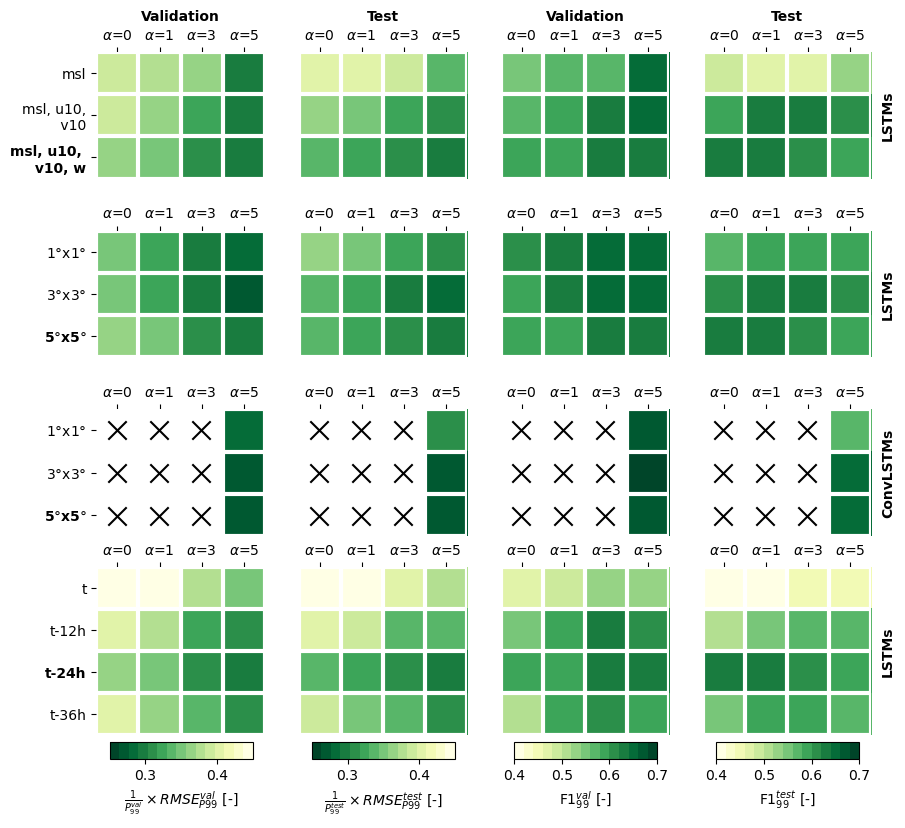

In [11]:
#plot sensitivity experiments heatmaps
store_fig=1
#list of experiments and labels per experiment:
quantile=.99

model = ['lstm','lstm','convlstm','lstm']
default_settings = [-1,-1,-1,-2]

test_dirs = [['msl','msl_u_v', 'nstep9'],
             ['1x1','3x3','nstep9'],
             ['1x1','3x3','nstep9'],
             ['nstep1','nstep5','nstep9','nstep13'],]

test_labels = [['msl','msl, u10,\n v10', 'msl, u10, \n v10, w'],
             [r'1$\degree$x1$\degree$',r'3$\degree$x3$\degree$',r'5$\degree$x5$\degree$'],
               [r'1$\degree$x1$\degree$',r'3$\degree$x3$\degree$',r'5$\degree$x5$\degree$'],
             ['t','t-12h','t-24h','t-36h'],]

tg        = 'esbjerg-esb-dnk-dmi.csv'

alphas = [0,1,3,5]
col_labels=[r'$\alpha$=0',r'$\alpha$=1',r'$\alpha$=3',r'$\alpha$=5']

fig=plt.figure(figsize=(10,9)) 
gs = fig.add_gridspec(len(test_dirs),4)
gs.update(top=.9,wspace=.2,hspace=.02)

for s,test_set in enumerate(test_dirs):
    for sp,split in enumerate(['val','test']):
        for m,metric in enumerate(['rmse_extremes','f1']):
            ds = model_datasets[model[s]]
            data = ds.sel(test=test_set,split=split,quantile=quantile).isel(tg=0)[metric].mean(dim='it')
            if model[s] =='convlstm':
                data=np.tile(data,4)
                data[:,0:3] = np.nan
            if metric=='rmse_extremes':
                data = data / ds.observed_thresholds.sel(tg=tg,test=test_set,split=split,quantile=quantile).values[0]
            
            ax = plt.subplot(gs[s,sp+m*2]) 
            if metric == 'rmse_extremes':
                cmap = plt.get_cmap('YlGn_r',15)
                if split=='val':
                    cbar_label = r'$\frac{{1}}{{P_{99}^{val}}} \times RMSE_{P99}^{val}$ [-]'
                else:
                    cbar_label = r'$\frac{{1}}{{P_{99}^{test}}} \times RMSE_{P99}^{test}$ [-]'
                vmin=.25
                vmax=.45
            else:
                cmap = plt.get_cmap('YlGn',15)
                if split=='val':
                    cbar_label = r'F1$_{99}^{val}$ [-]'
                else:
                    cbar_label = r'F1$_{99}^{test}$ [-]'
                vmin=.4
                vmax=.7
                    
            im = ax.imshow(data,vmin=vmin,vmax=vmax,cmap=cmap) # Plot the heatmap
            
            if model[s]=='convlstm':
                for i in np.arange(3):
                    ax.scatter([.12+i*.25],[.16],marker='x',s=175,c=['black'],transform=ax.transAxes,zorder=10)
                    ax.scatter([.12+i*.25],[.5],marker='x',s=175,c=['black'],transform=ax.transAxes,zorder=10)
                    ax.scatter([.12+i*.25],[.84],marker='x',s=175,c=['black'],transform=ax.transAxes,zorder=10)

            if s==0:
                ax.text(.5,1.25,['Validation','Test'][sp],transform=ax.transAxes,fontweight='bold',ha='center')
            if (metric=='f1') & (split=='test'):
                ax.text(1.1,.5,model[s].upper().replace('CONV','Conv')+'s',transform=ax.transAxes,fontweight='bold',rotation=90, ha="center",va='center')   
                
            # Create colorbar
            if s==len(test_dirs)-1:
                cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(.12, -.1,.85,.1),bbox_transform=ax.transAxes)
                fig.colorbar(im, cax=cax,orientation='horizontal',label=cbar_label)
            
            if sp+m==0:
                ax.set_yticks(range(data.shape[0]), labels=test_labels[s])
                ax.get_yticklabels()[default_settings[s]].set_fontweight("bold")
            else:
                ax.set_yticks([])

            ax.set_xticks(range(data.shape[1]), labels=col_labels,
                          rotation=0, ha="center")
            
            # Let the horizontal axes labeling appear on top.
            ax.tick_params(top=True, bottom=False,
                           labeltop=True, labelbottom=False)

            # Turn spines off and create white grid.
            ax.spines[:].set_visible(False)
        
            ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
            ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
            ax.set_facecolor('white')
            ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
            ax.tick_params(which="minor", bottom=False, left=False)
            
if store_fig:
    fig.savefig('nhess_figures/figA1_sensitivity_esbjerg.jpg',format='jpg',dpi=300,bbox_inches='tight') #store figure